# Learner

> Building a framework for the deep learning workflow

Adapted from:
- https://youtu.be/0Hi2r4CaHvk?si=GA9KaGAnGOlS_NJO&t=3568
- https://github.com/fastai/course22p2/blob/master/nbs/09_learner.ipynb

In [1]:
# |default_exp learner

In [2]:
# |export
import math
import tempfile
from copy import copy
from functools import lru_cache, partial
from pathlib import Path
from typing import Mapping, Type

import fastcore.all as fc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchmetrics
import torchvision.transforms as T
from datasets import load_dataset
from fastprogress import master_bar, progress_bar
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, default_collate

from slowai.autoencoders import get_model as get_ae_model
from slowai.convs import def_device, fit, to_device
from slowai.datasets import show_images

At this point, Jeremy points out that copying and pasting code leads to bottlenecks in modeling velocity. We need to start to build a framework to:

- rapidly try things
- figure out where things are broken
- load data quickly
- transparently assign CUDA devices

## Data

We'll start with a wrapper around `datasets` to make it simpler to work with raw PyTorch.

In [3]:
# |export
class DataLoaders:
    def __init__(
        self,
        splits,
        nworkers: int = 0,
        bs=32,
        collate_fn=default_collate,
        tdir=tempfile.TemporaryDirectory(),
    ):
        fc.store_attr()

    @classmethod
    def from_dsd(cls, dsd, **kwargs):
        return cls(splits=dsd, **kwargs)

    @classmethod
    def from_hf(cls, dataset_id, **kwargs):
        dsd = load_dataset(dataset_id)
        return cls.from_dsd(dsd, **kwargs)

    def with_transforms(self, ts, batched=True, lazy=False):
        def map_(batch):
            for feature, transform in ts.items():
                batch[feature] = transform(batch[feature])
            return batch

        if lazy:
            assert batched, "Lazy transforms must be batched"
            # TODO: make this accretive
            self.splits.set_transform(map_)
        else:
            self.splits = self.splits.map(map_, batched=batched)

        return self

    def listify(self):
        """Yield a list instead of a dictionary"""
        s = copy(self)

        def collate_fn(examples):
            cols = default_collate(examples)
            return [cols[f] for f in self.splits["train"].features]

        s.collate_fn = collate_fn
        return s

    def dl(self, split, nworkers=None):
        ds = self.splits[split]
        nworkers = nworkers or self.nworkers
        if nworkers > 0:
            dir_ = Path(tdir) / split
            if not dir_.exists():
                ds.save_to_disk(dir_)
            ds = load_from_disk(dir_)
        return DataLoader(
            ds,
            batch_size=self.bs,
            collate_fn=self.collate_fn,
            num_workers=nworkers,
        )

    def peek(self, split="train"):
        dl = self.dl(split, nworkers=0)
        batch = next(iter(dl))
        return batch

    @lru_cache
    def __getitem__(self, split):
        return self.dl(split)

In [4]:
dls = DataLoaders.from_hf("fashion_mnist")

We should also add some helpers to facilitate processing images.

In [5]:
# |export
pipe = [T.PILToTensor(), T.ConvertImageDtype(torch.float)]
to_tensor = T.Compose(pipe)


def batchify(f):
    def inner_(batch):
        return [f(example) for example in batch]

    return inner_


def tensorize_images(dls, feature="image", normalize=True):
    """Tensorize and normalize the image feature"""
    if normalize:
        # Sample 100 images to estimate the mean and standard deviation
        imgs = dls.splits["train"].shuffle()[:100]["image"]
        pixels = torch.stack([to_tensor(img) for img in imgs]).view(-1)
        mu = pixels.mean()
        sigma = pixels.std()
        to_norm_tensor = T.Compose([*pipe, T.Normalize([mu], [sigma])])
        return dls.with_transforms({"image": batchify(to_norm_tensor)}, lazy=True)
    else:
        return dls.with_transforms({"image": batchify(to_tensor)}, lazy=True)

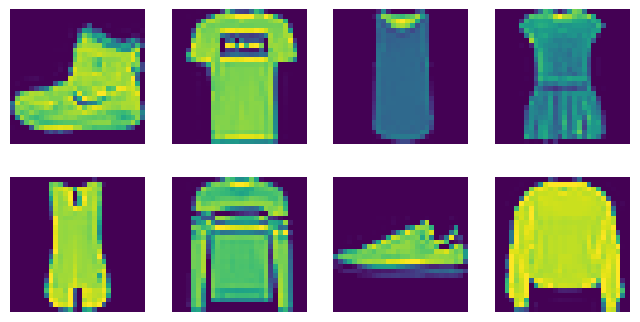

In [6]:
dls = tensorize_images(dls)
xb = dls.peek()["image"]
show_images(xb[:8, ...], figsize=(8, 4))

Notice that this unit-normalized

(array([13418.,   607.,   687.,  1014.,  1057.,  1076.,  1408.,  2054.,
         2393.,  1374.]),
 array([-0.80131918, -0.51861167, -0.23590422,  0.04680327,  0.32951075,
         0.61221826,  0.89492571,  1.17763317,  1.46034074,  1.74304819,
         2.02575564]),
 <BarContainer object of 10 artists>)

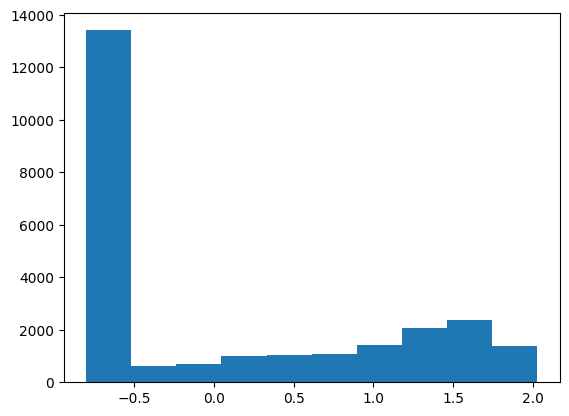

In [7]:
plt.hist(xb.view(-1))

## Learner and callbacks

Next, we'll add a learner with callbacks. Recall, this was our earlier fit function:

In [8]:
fit??

Signature: fit(epochs, model, loss_func, opt, train_dl, valid_dl, tqdm_=False)
Docstring: <no docstring>
Source:   
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, tqdm_=False):
    progress = tqdm if tqdm_ else lambda x: x
    for epoch in range(epochs):
        model.train()
        for batch in progress(train_dl):
            xb, yb = map(to_device, batch)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.0, 0.0, 0
            for batch in progress(valid_dl):
                xb, yb = map(to_device, batch)
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n

        print(
            f"{epoch=}, validation loss={tot_loss / count:.3f}, validation accuracy={tot_

To add callbacks, we need a few clever Exception control flow signals

In [9]:
# |export
class CancelFitException(Exception):
    ...


class CancelBatchException(Exception):
    ...


class CancelEpochException(Exception):
    ...

Then, we define the learner and callback classes

In [10]:
# |export
class Callback:
    def __init_subclass__(cls, order=0) -> None:
        cls.order = order
        super().__init_subclass__()

In [11]:
# |export
class with_cbs:
    def __init__(self, nm):
        self.nm = nm

    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f"before_{self.nm}")
                f(o, *args, **kwargs)
                o.callback(f"after_{self.nm}")
            except globals()[f"Cancel{self.nm.title()}Exception"]:
                pass
            finally:
                o.callback(f"cleanup_{self.nm}")

        return _f

In [31]:
# |export
class Learner:
    def __init__(
        self,
        model,
        dls,
        loss_func=F.mse_loss,
        lr=0.1,
        cbs=None,
        opt_func=optim.SGD,
    ):
        cbs = fc.L(cbs)
        fc.store_attr()

    def run_cbs(self, method_nm):
        for cb in sorted(self.cbs, key=lambda cb: cb.order):
            method = getattr(cb, method_nm, None)
            if method is not None:
                method(self)

    @with_cbs("batch")
    def _one_batch(self):
        self.predict()
        self.callback("after_predict")
        self.get_loss()
        self.callback("after_loss")
        if self.training:
            self.backward()
            self.callback("after_backward")
            self.step()
            self.callback("after_step")
            self.zero_grad()

    @with_cbs("epoch")
    def _one_epoch(self):
        for self.iter, self.batch in enumerate(self.dl):
            self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        # Note that __getattr__ is lru_cache'd
        # TODO: test whether this actually makes things faster
        self.dl = self.dls["train" if training else "test"]
        self._one_epoch()

    @with_cbs("fit")
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train:
                self.one_epoch(True)
            if valid:
                torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        with tempfile.TemporaryDirectory() as tdir:
            self.dls.tdir = tdir
            cbs = fc.L(cbs)
            # `add_cb` and `rm_cb` were added in lesson 18
            for cb in cbs:
                self.cbs.append(cb)
            try:
                self.n_epochs = n_epochs
                self.epochs = range(n_epochs)
                if lr is None:
                    lr = self.lr
                if self.opt_func:
                    self.opt = self.opt_func(self.model.parameters(), lr)
                self._fit(train, valid)
            finally:
                for cb in cbs:
                    self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ("predict", "get_loss", "backward", "step", "zero_grad"):
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm):
        self.run_cbs(method_nm)

    @property
    def training(self):
        return self.model.training

This learner delegates all aspects of model training to callbacks, so something like this is neccesary.

In [13]:
# |export
class TrainCB(Callback):
    def predict(self, learn):
        xb = learn.batch
        learn.preds = learn.model(*xb)

    def get_loss(self, learn):
        _, yb = learn.batch
        learn.loss = learn.loss_func(learn.preds, yb)

    def backward(self, learn):
        learn.loss.backward()

    def step(self, learn):
        learn.opt.step()

    def zero_grad(self, learn):
        learn.opt.zero_grad()

Now that we have the basic scaffolding, we'll add metrics. Updating and storing state will be handled by `torchmetrics`, but we'll define a callback to orchestrate the torchmetrics instances.

In [14]:
# |export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics["loss"] = self.loss = torchmetrics.aggregation.MeanMetric()

    def _log(self, d):
        print(d)

    def before_fit(self, learn):
        learn.metrics = self

    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f"{v.compute():.3f}" for k, v in self.all_metrics.items()}
        log["epoch"] = learn.epoch
        log["train"] = "train" if learn.model.training else "eval"
        self._log(log)

    def after_batch(self, learn):
        x, y, *_ = learn.batch
        x = x.cpu()
        y = y.cpu()
        for m in self.metrics.values():
            m.update(learn.preds.cpu(), y)
        self.loss.update(learn.loss.cpu(), weight=len(x))

Finally, we can define a Trainer callback specifically for the autoencoder objective.

In [15]:
class TrainAutoencoderCB(TrainCB):
    def predict(self, learn):
        xb, *_ = learn.batch
        learn.preds = learn.model(xb)

    def get_loss(self, learn):
        xb, *_ = learn.batch
        learn.loss = learn.loss_func(learn.preds, xb)

Let's also define some additional useful callbacks:

In [16]:
# |export
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        fc.store_attr()

    def before_fit(self, learn):
        if hasattr(learn.model, "to"):
            learn.model.to(self.device)

    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)


def after(callback_cls: str | Type[Callback]):
    if isinstance(callback_cls, str):
        callback_cls = eval(callback_cls)
    return callback_cls.order + 1


class ProgressCB(Callback, order=after(MetricsCB)):
    def __init__(self, plot=False):
        self.plot = plot

    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, "metrics"):
            learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)

    def after_batch(self, learn):
        learn.dl.comment = f"{learn.loss:.3f}"
        if self.plot and hasattr(learn, "metrics") and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                x = [fc.L.range(self.losses), self.losses]
                steps = fc.L.range(learn.epoch).map(
                    lambda x: (x + 1) * len(learn.dls["train"])
                )
                y = [steps, self.val_losses]
                self.mbar.update_graph([x, y])

    def after_epoch(self, learn):
        if not learn.training:
            if self.plot and hasattr(learn, "metrics"):
                self.val_losses.append(learn.metrics.all_metrics["loss"].compute())
                x = [fc.L.range(self.losses), self.losses]
                steps = fc.L.range(learn.epoch + 1).map(
                    lambda x: (x + 1) * len(learn.dls["train"])
                )
                y = [steps, self.val_losses]
                self.mbar.update_graph([x, y])

Putting it all together

In [17]:
# |export
def fashion_mnist():
    return tensorize_images(DataLoaders.from_hf("fashion_mnist", bs=2048)).listify()

loss,epoch,train
1.188,0,train
0.989,0,eval
0.805,1,train
0.726,1,eval


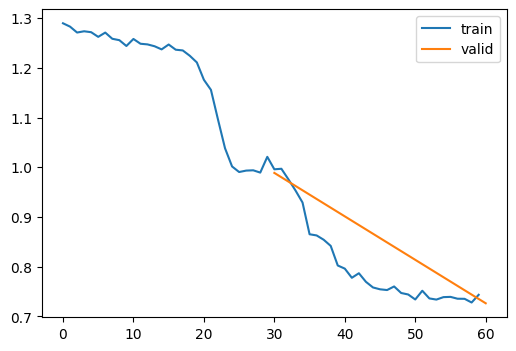

CPU times: user 24.5 s, sys: 1.37 s, total: 25.9 s
Wall time: 25.7 s


In [18]:
%%time
model = get_ae_model()
dls = fashion_mnist()
cbs = [
    MetricsCB(),
    DeviceCB(),
    TrainAutoencoderCB(),
    ProgressCB(plot=True),
]
learn = Learner(
    model,
    dls,
    F.mse_loss,
    lr=0.01,
    cbs=cbs,
    opt_func=torch.optim.AdamW,
).fit(2)

In [19]:
def viz(model, xb):
    xb = xb.to(def_device)
    pred = model(xb)
    paired = []
    for i in range(min(xb.shape[0], 8)):
        paired.append(xb[i, ...])
        paired.append(pred[i, ...])
    show_images(paired, figsize=(8, 8))

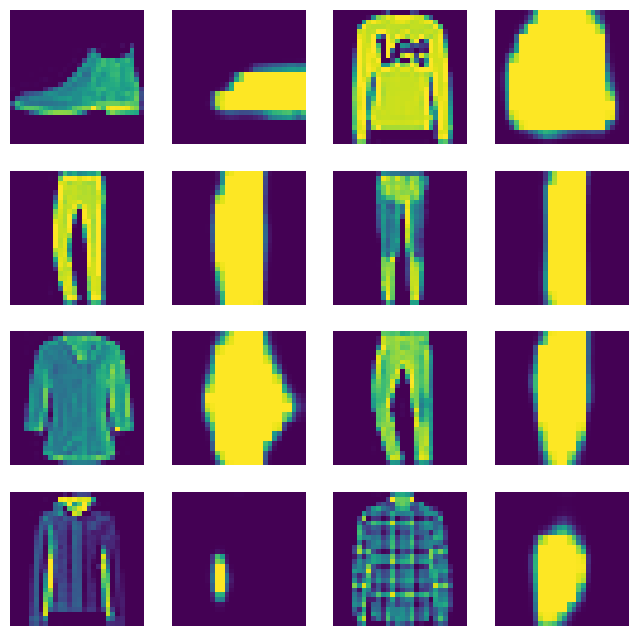

In [20]:
xbt, _ = dls.peek("test")
viz(model, xbt)

Still not good, but less code!

I don't really like the idea of delegating the core training functions to callbacks, so we can just implement them here:

In [21]:
# |export
class TrainLearner(Learner):
    def predict(self):
        xb, yb = self.batch
        self.preds = self.model(xb)

    def get_loss(self):
        xb, yb = self.batch
        self.loss = self.loss_func(self.preds, yb)

    def backward(self):
        self.loss.backward()

    def step(self):
        self.opt.step()

    def zero_grad(self):
        self.opt.zero_grad()

This works pretty similarly

loss,epoch,train
1.002,0,train
0.783,0,eval
0.750,1,train
0.716,1,eval


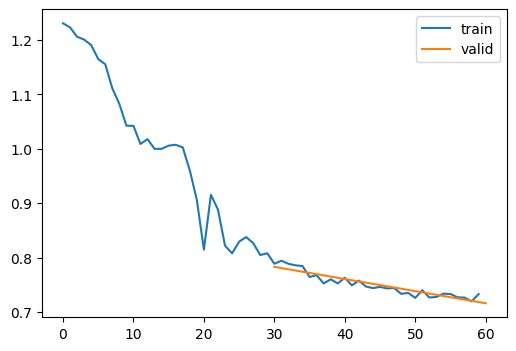

CPU times: user 22.1 s, sys: 126 ms, total: 22.2 s
Wall time: 22.2 s


In [22]:
%%time
class AutoencoderTrainer(TrainLearner):
    def predict(self):
        xb, *_ = self.batch
        self.preds = self.model(xb)

    def get_loss(self):
        xb, *_ = self.batch
        self.loss = self.loss_func(self.preds, xb)


cbs = [MetricsCB(), DeviceCB(), ProgressCB(plot=True)]
learn = AutoencoderTrainer(
    get_ae_model(),
    dls,
    F.mse_loss,
    lr=0.01,
    cbs=cbs,
    opt_func=torch.optim.AdamW,
).fit(2)

Can we improve the reconstruction? Let's implement a simple momentum.

loss,epoch,train
1.216,0,train
1.176,0,eval
1.156,1,train
1.126,1,eval


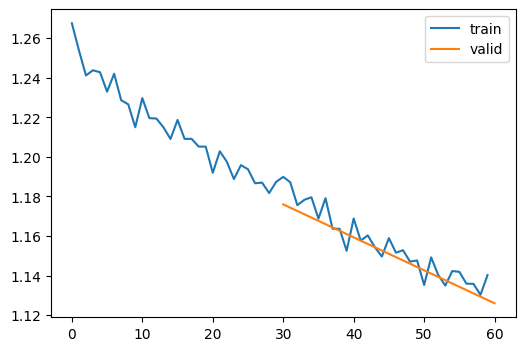

CPU times: user 22.2 s, sys: 143 ms, total: 22.3 s
Wall time: 22.3 s


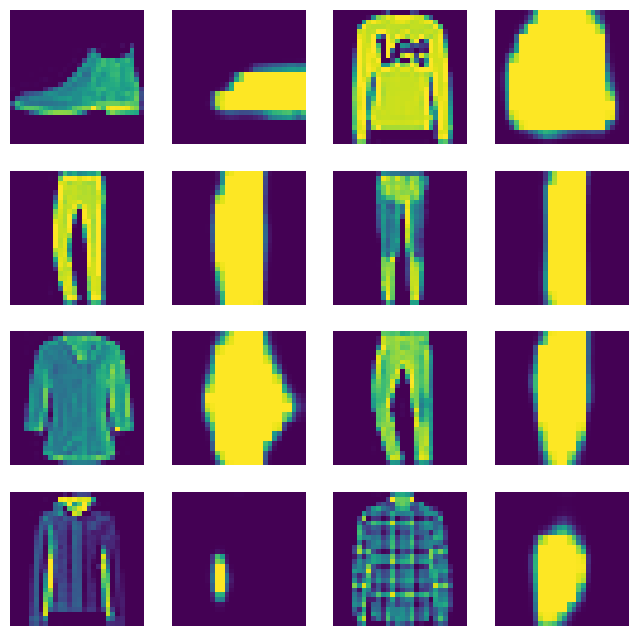

In [23]:
%%time
class MomentumCB(Callback):
    def __init__(self, momentum=0.85):
        self.momentum = momentum

    def zero_grad(self, learn):
        with torch.no_grad():
            for p in learn.model.parameters():
                p.grad *= self.momentum


cbs = [MetricsCB(), DeviceCB(), ProgressCB(plot=True), MomentumCB()]
learn = AutoencoderTrainer(
    get_ae_model(),
    dls,
    F.mse_loss,
    lr=0.01,
    cbs=cbs,
    opt_func=torch.optim.AdamW,
).fit(2)
viz(model, xbt)

Not especially impressive.

What about using the automated learning rate finder?

In [24]:
# |export
def to_cpu(x):
    if isinstance(x, Mapping):
        return {k: to_cpu(v) for k, v in x.items()}
    if isinstance(x, list):
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype == torch.float16 else res

In [25]:
# |export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3):
        fc.store_attr()

    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs, self.losses = [], []
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]["lr"])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if math.isnan(loss) or (loss > self.min * self.max_mult):
            raise CancelFitException

        # Decays the learning rate of each parameter group by gamma every epoch.
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html

        self.sched.step()

    def cleanup_fit(self, learn):
        fig, ax = plt.subplots()
        ax.plot(self.lrs, self.losses)
        ax.set_xscale("log")

In [26]:
# |export
@fc.patch
def lr_find(self: Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))
    return self

loss,epoch,train
1.193,0,train
0.967,1,train


/home/jeremy/micromamba/envs/slowai/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered `nan` values in tensor. Will be removed.
  warnings.warn(*args, **kwargs)  # noqa: B028


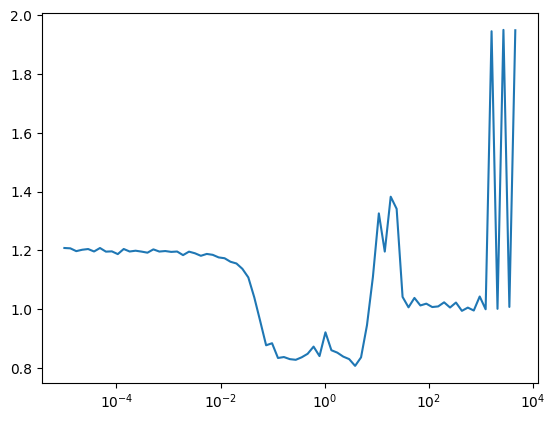

In [27]:
learn = AutoencoderTrainer(
    get_ae_model(),
    dls,
    F.mse_loss,
    lr=1e-5,
    cbs=cbs,
    opt_func=torch.optim.AdamW,
).lr_find()

It looks like 1e-2 is a good learning rate.

loss,epoch,train
1.193,0,train
1.156,0,eval
1.138,1,train
1.111,1,eval


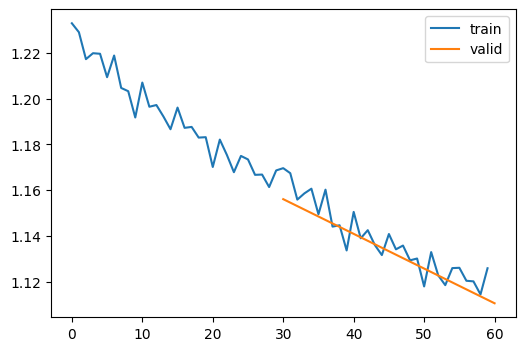

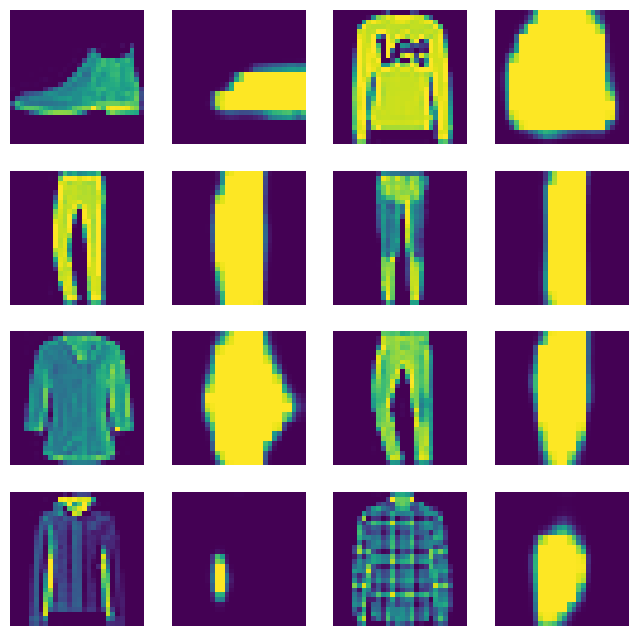

In [28]:
cbs = [MetricsCB(), DeviceCB(), ProgressCB(plot=True), MomentumCB()]
learn = AutoencoderTrainer(
    get_ae_model(),
    dls,
    F.mse_loss,
    lr=1e-2,
    cbs=cbs,
    opt_func=torch.optim.AdamW,
).fit(2)
viz(model, xbt)

Again, not especially impressive.

We'll write some tool to diagnose model issues in the next notebook.

In [32]:
# |hide
import nbdev

nbdev.nbdev_export()